<a href="https://colab.research.google.com/github/ramapriyakj/yelp/blob/master/YelpAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integration with google drive.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
data_set_dir = root_dir + 'Colab Notebooks/dataset/yelp/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Yelp Data Analysis**

In this project we perform sentimental analysis on yelp data set (https://www.yelp.com/dataset ).

review.json file is used to perform sentimental analysis on businesses.

Only first 200000 (positive + negative) reviews are extracted from the dataset and analysis is performed.

user ratings > 3 are positive else negative.

Final classification accuracies by different models are reported :


1.   RF - Random forest classifier
2.   DENSE - Dense feed forward network
3.   RNN - Simple recurrent neural network 
4.   LSTM - Long short term memory 
5.   BI-LSTM - Bi directional LSTM 
6.   CONV - Processing with COVNET


Review JSON path

In [0]:
import os,sys
review_path = data_set_dir + "review.json";
if os.path.isfile(review_path):
    pass
else:
    print("Invalid file path. Please place the python file in the same folder as review.json and rerun.")
    sys.exit(0)

Required libraries

In [3]:
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


Read json

In [4]:
max_records = 100000
x_raw = []
y_raw = []
reviews = pd.read_json(review_path,lines=True,chunksize=max_records)
pos = 0
neg = 0
for chunks in reviews:
  if len(y_raw) == max_records*2:
    break
  for index, rec in chunks.iterrows():
    y = rec["stars"]
    if pos < max_records and y > 3:            
      pos = pos + 1
      x_raw.append(rec["text"])
      y_raw.append(1)
    elif neg < max_records:
      neg = neg + 1
      x_raw.append(rec["text"])
      y_raw.append(0)
      
print("Length of data : ",len(x_raw))

Length of data :  200000


Only first 150 words are used for review (**input_shape**).

**vocab_len** is a parameter which is used to train Embedding layer whose size is equal to the number of unique words in sequences.

In [0]:
input_shape = 100
vocab_len = None

* Stop words which doesn't add much meaning to the sequences are filtered.
* Tokens are padded to same length and vectorized

In [6]:
x_text = []
for w in x_raw:
    arr = [s for s in text_to_word_sequence(w) if not s in STOPWORDS]  
    x_text.append(arr)
t = Tokenizer()
t.fit_on_texts(x_text)
vocab_len = len(t.word_index) + 1

sequences = t.texts_to_sequences(x_text)
data = pad_sequences(sequences, maxlen=input_shape)
labels = np.asarray(y_raw)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (200000, 100)
Shape of label tensor: (200000,)


Split data into train, test and validation set.

In [7]:
x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size=0.1,random_state=101)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=102)
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val:', x_val.shape)
print('y_val:', y_val.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (162000, 100)
y_train: (162000,)
x_val: (18000, 100)
y_val: (18000,)
x_test: (20000, 100)
y_test: (20000,)


Function return model of specified type

* name: Name of the model 
* vocab_len : Embedding vocabulary size
* inp_shape : Input shape

In [0]:
def getModel(name,vocab_len,inp_shape):
    if name == "DENSE":
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(inp_shape,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "RNN":
        model = Sequential()
        model.add(Embedding(vocab_len, 64))
        model.add(SimpleRNN(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
        model.add(SimpleRNN(32, dropout=0.1, recurrent_dropout=0.1))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "LSTM":
        model = Sequential()
        model.add(Embedding(vocab_len, 64))
        model.add(LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
        model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "BI-LSTM":
        model = Sequential()
        model.add(Embedding(vocab_len, 64))
        model.add(Bidirectional(LSTM(32, return_sequences=True,dropout=0.1, recurrent_dropout=0.1)))
        model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.1)))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "CONV":
        model = Sequential()
        model.add(Embedding(vocab_len, 64))
        model.add(Conv1D(32, 7, activation='relu'))
        model.add(MaxPooling1D(5))
        model.add(Conv1D(32, 7, activation='relu'))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "RF":
        model = RandomForestClassifier(verbose=0,n_jobs=-1,random_state=136)
        return model
    

Plot accuracies

In [0]:
def plot_accuracy(model_name,history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(model_name+' - Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Train model and predict accuracies

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of  RF  :  54.17
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 7s 46us/step - loss: 7.7596 - acc: 0.5152 - val_loss: 8.0353 - val_acc: 0.4960
Epoch 2/5
162000/162000 [==============================] - 5s 28us/step - loss: 7.7694 - acc: 0.5130 - val_loss: 8.0491 - val_acc: 0.4951
Epoch 3/5
162000/162000 [==============================] - 4s 26us/step - loss: 7.6112 - acc: 0.5235 - val_loss: 7.4651 - val_acc: 0.5338
Epoch 4/5
162000/162000 [==============================] - 4s 25us/step - loss: 7.4361 - acc: 0.5355 - val_loss: 7.9327 - val_acc: 0.5024
Epoch 5/5
162000/162000 [==============================] - 4s 25us/step - loss: 7.9549 - acc: 0.5010 - val_loss: 8.0732 - val_acc: 0.4936


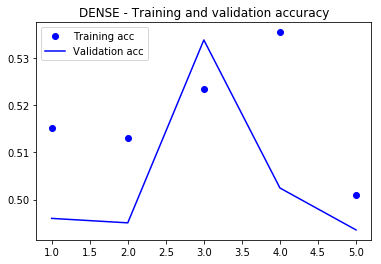

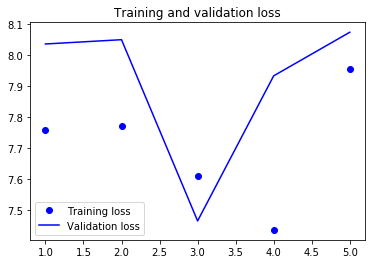

Accuracy of  DENSE  :  50.49
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 106s 652us/step - loss: 0.5951 - acc: 0.6642 - val_loss: 0.5473 - val_acc: 0.7339
Epoch 2/5
162000/162000 [==============================] - 106s 653us/step - loss: 0.5338 - acc: 0.7376 - val_loss: 0.5377 - val_acc: 0.7343
Epoch 3/5
162000/162000 [==============================] - 106s 655us/step - loss: 0.5238 - acc: 0.7431 - val_loss: 0.5254 - val_acc: 0.7411
Epoch 4/5
162000/162000 [==============================] - 104s 644us/step - loss: 0.5144 - acc: 0.7504 - val_loss: 0.5275 - val_acc: 0.7375
Epoch 5/5
162000/162000 [==============================] - 106s 653us/step - loss: 0.5064 - acc: 0.7567 - val_loss: 0.5313 - val_acc: 0.7446


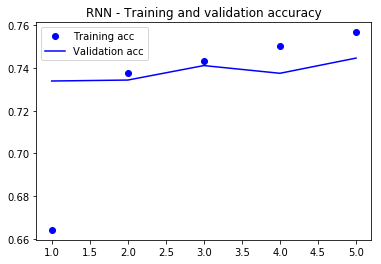

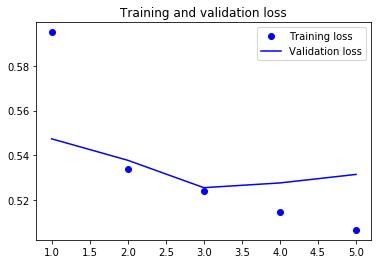

Accuracy of  RNN  :  75.04
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 415s 3ms/step - loss: 0.5246 - acc: 0.7398 - val_loss: 0.5065 - val_acc: 0.7515
Epoch 2/5
162000/162000 [==============================] - 414s 3ms/step - loss: 0.4916 - acc: 0.7628 - val_loss: 0.5055 - val_acc: 0.7537
Epoch 3/5
162000/162000 [==============================] - 415s 3ms/step - loss: 0.4781 - acc: 0.7727 - val_loss: 0.5008 - val_acc: 0.7522
Epoch 4/5
162000/162000 [==============================] - 414s 3ms/step - loss: 0.4670 - acc: 0.7797 - val_loss: 0.5038 - val_acc: 0.7498
Epoch 5/5
162000/162000 [==============================] - 414s 3ms/step - loss: 0.4550 - acc: 0.7860 - val_loss: 0.5071 - val_acc: 0.7479


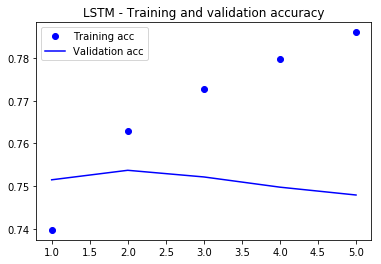

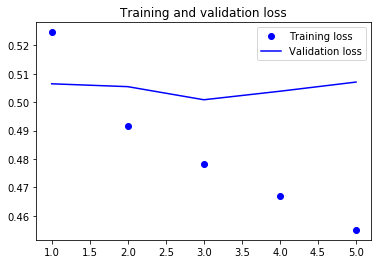

Accuracy of  LSTM  :  75.25
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 831s 5ms/step - loss: 0.5228 - acc: 0.7403 - val_loss: 0.5151 - val_acc: 0.7499
Epoch 2/5
162000/162000 [==============================] - 829s 5ms/step - loss: 0.4904 - acc: 0.7635 - val_loss: 0.5015 - val_acc: 0.7533
Epoch 3/5
162000/162000 [==============================] - 825s 5ms/step - loss: 0.4781 - acc: 0.7724 - val_loss: 0.5039 - val_acc: 0.7537
Epoch 4/5
162000/162000 [==============================] - 827s 5ms/step - loss: 0.4641 - acc: 0.7820 - val_loss: 0.5218 - val_acc: 0.7486
Epoch 5/5
162000/162000 [==============================] - 825s 5ms/step - loss: 0.4499 - acc: 0.7901 - val_loss: 0.5264 - val_acc: 0.7488


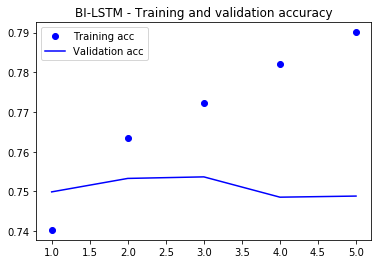

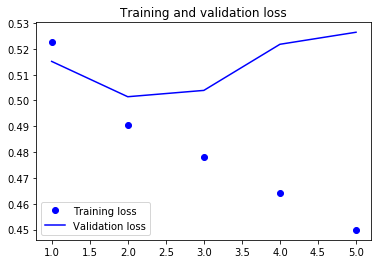

Accuracy of  BI-LSTM  :  75.45
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 17s 105us/step - loss: 0.6491 - acc: 0.6101 - val_loss: 0.5653 - val_acc: 0.7080
Epoch 2/5
162000/162000 [==============================] - 11s 69us/step - loss: 0.5320 - acc: 0.7368 - val_loss: 0.5310 - val_acc: 0.7369
Epoch 3/5
162000/162000 [==============================] - 11s 69us/step - loss: 0.5114 - acc: 0.7511 - val_loss: 0.5257 - val_acc: 0.7404
Epoch 4/5
162000/162000 [==============================] - 11s 69us/step - loss: 0.5014 - acc: 0.7574 - val_loss: 0.5238 - val_acc: 0.7406
Epoch 5/5
162000/162000 [==============================] - 11s 69us/step - loss: 0.4945 - acc: 0.7621 - val_loss: 0.5224 - val_acc: 0.7445


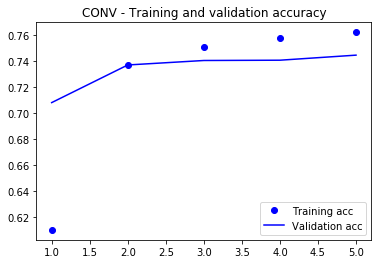

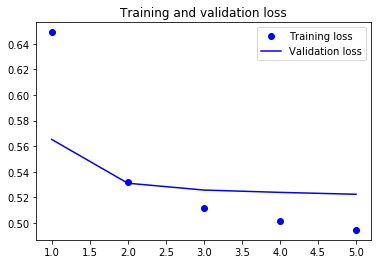

Accuracy of  CONV  :  74.51


In [10]:
model_list = ["RF","DENSE","RNN","LSTM","BI-LSTM","CONV"]
model_accuracies = []
cls_reports = []
for name in model_list:
    model = getModel(name,vocab_len,input_shape)
    y_pred = None
    
    if name == "DENSE" or name == "RNN" or name == "LSTM" or name == "BI-LSTM" or name == "CONV":
        history = model.fit(x_train, y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val)) 
        plot_accuracy(name,history)
        y_pred = model.predict_classes(x_test)        
    elif name == "RF":
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
    model_accuracies.append(round(accuracy_score(y_test,y_pred)*100,2))
    print("Accuracy of ",name," : ",model_accuracies[-1])
    cls_reports.append(precision_recall_fscore_support(y_test,y_pred, average='micro'))

In [11]:
from prettytable import PrettyTable
print("Testing results:")
t = PrettyTable(['Model','Acuracy','Precision','Recall','F1-Score'])
for a,b,c in zip(model_list,model_accuracies,cls_reports):
    t.add_row([a,b,c[0],c[1],c[2]])
print(t)

Testing results:
+---------+---------+-----------+--------+--------------------+
|  Model  | Acuracy | Precision | Recall |      F1-Score      |
+---------+---------+-----------+--------+--------------------+
|    RF   |  54.17  |   0.5417  | 0.5417 |       0.5417       |
|  DENSE  |  50.49  |   0.5049  | 0.5049 |       0.5049       |
|   RNN   |  75.04  |   0.7504  | 0.7504 |       0.7504       |
|   LSTM  |  75.25  |   0.7525  | 0.7525 |       0.7525       |
| BI-LSTM |  75.45  |   0.7545  | 0.7545 | 0.7545000000000001 |
|   CONV  |  74.51  |   0.7451  | 0.7451 |       0.7451       |
+---------+---------+-----------+--------+--------------------+
